In [19]:
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import os
print(os.listdir("data"))
import cv2
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # RGB color


['test', 'train']


In [40]:
filenames = os.listdir("data/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'human':
        categories.append(str(1))
    else:
        categories.append(str(0))

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [41]:
df.head()


,filename,category
0,human.0.jpg,1
1,human.1.jpg,1
2,human.10.jpg,1
3,human.100.jpg,1
4,human.1000.jpg,1


In [42]:
df['category'].astype(str)




0       1
1       1
2       1
3       1
4       1
5       1
6       1
7       1
8       1
9       1
10      1
11      1
12      1
13      1
14      1
15      1
16      1
17      1
18      1
19      1
20      1
21      1
22      1
23      1
24      1
25      1
26      1
27      1
28      1
29      1
       ..
9612    0
9613    0
9614    0
9615    0
9616    0
9617    0
9618    0
9619    0
9620    0
9621    0
9622    0
9623    0
9624    0
9625    0
9626    0
9627    0
9628    0
9629    0
9630    0
9631    0
9632    0
9633    0
9634    0
9635    0
9636    0
9637    0
9638    0
9639    0
9640    0
9641    0
Name: category, Length: 9642, dtype: object

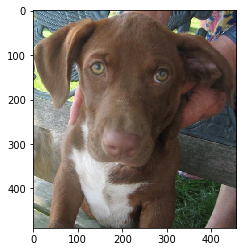

In [43]:
sample = random.choice(filenames)
image = load_img("data/train/"+sample)
plt.imshow(image)

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_v2_4 (Ba (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_v2_5 (Ba (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)       

In [59]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [62]:
earlystop = EarlyStopping(patience=10)


In [63]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [64]:
callbacks = [earlystop, learning_rate_reduction]


In [65]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

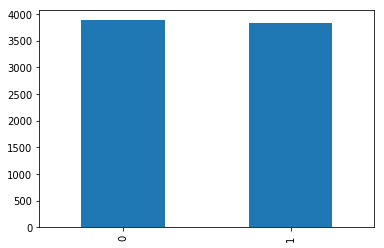

In [66]:
train_df['category'].value_counts().plot.bar()


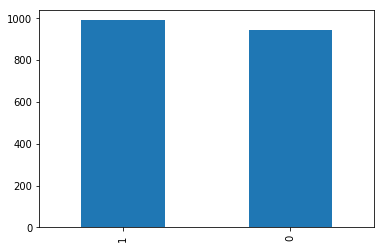

In [67]:
validate_df['category'].value_counts().plot.bar()


In [68]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [69]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 7713 images belonging to 2 classes.


In [70]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 1929 images belonging to 2 classes.


In [72]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
513/514 [============================>.] - ETA: 1s - loss: 0.1938 - accuracy: 0.9304

W0408 17:20:29.613399  1056 callbacks.py:1485] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


514/514 [==============================] - 574s 1s/step - loss: 0.1944 - accuracy: 0.9302 - val_loss: 0.0822 - val_accuracy: 0.9708
Epoch 2/50
513/514 [============================>.] - ETA: 0s - loss: 0.1331 - accuracy: 0.9501

W0408 17:28:15.321398  1056 callbacks.py:1485] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


514/514 [==============================] - 466s 906ms/step - loss: 0.1329 - accuracy: 0.9502 - val_loss: 0.1407 - val_accuracy: 0.9495
Epoch 3/50
513/514 [============================>.] - ETA: 0s - loss: 0.0979 - accuracy: 0.9667

W0408 17:35:56.312382  1056 callbacks.py:1485] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


514/514 [==============================] - 461s 897ms/step - loss: 0.0978 - accuracy: 0.9667 - val_loss: 0.0141 - val_accuracy: 0.9948
Epoch 4/50
513/514 [============================>.] - ETA: 0s - loss: 0.0823 - accuracy: 0.9747

W0408 17:43:35.679451  1056 callbacks.py:1485] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


514/514 [==============================] - 459s 894ms/step - loss: 0.0822 - accuracy: 0.9748 - val_loss: 2.0728 - val_accuracy: 0.4969
Epoch 5/50
513/514 [============================>.] - ETA: 0s - loss: 0.0756 - accuracy: 0.9753

W0408 17:51:16.850753  1056 callbacks.py:1485] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


514/514 [==============================] - 461s 897ms/step - loss: 0.0754 - accuracy: 0.9753 - val_loss: 0.2995 - val_accuracy: 0.8833
Epoch 6/50
513/514 [============================>.] - ETA: 0s - loss: 0.0646 - accuracy: 0.9781

W0408 17:58:57.344279  1056 callbacks.py:1485] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


514/514 [==============================] - 460s 896ms/step - loss: 0.0644 - accuracy: 0.9782 - val_loss: 0.0669 - val_accuracy: 0.9729
Epoch 7/50
222/514 [===========>..................] - ETA: 4:19 - loss: 0.0752 - accuracy: 0.9790

KeyboardInterrupt: 

In [73]:
model.save_weights("model.h5")


In [75]:
test_filenames = os.listdir("data/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [77]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "data/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 2412 images.


In [78]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [81]:
threshold = 0.5
test_df['probability'] = predict
test_df['category'] = np.where(test_df['probability'] > threshold, 1,0)

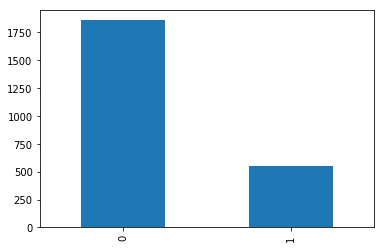

In [82]:
test_df['category'].value_counts().plot.bar()


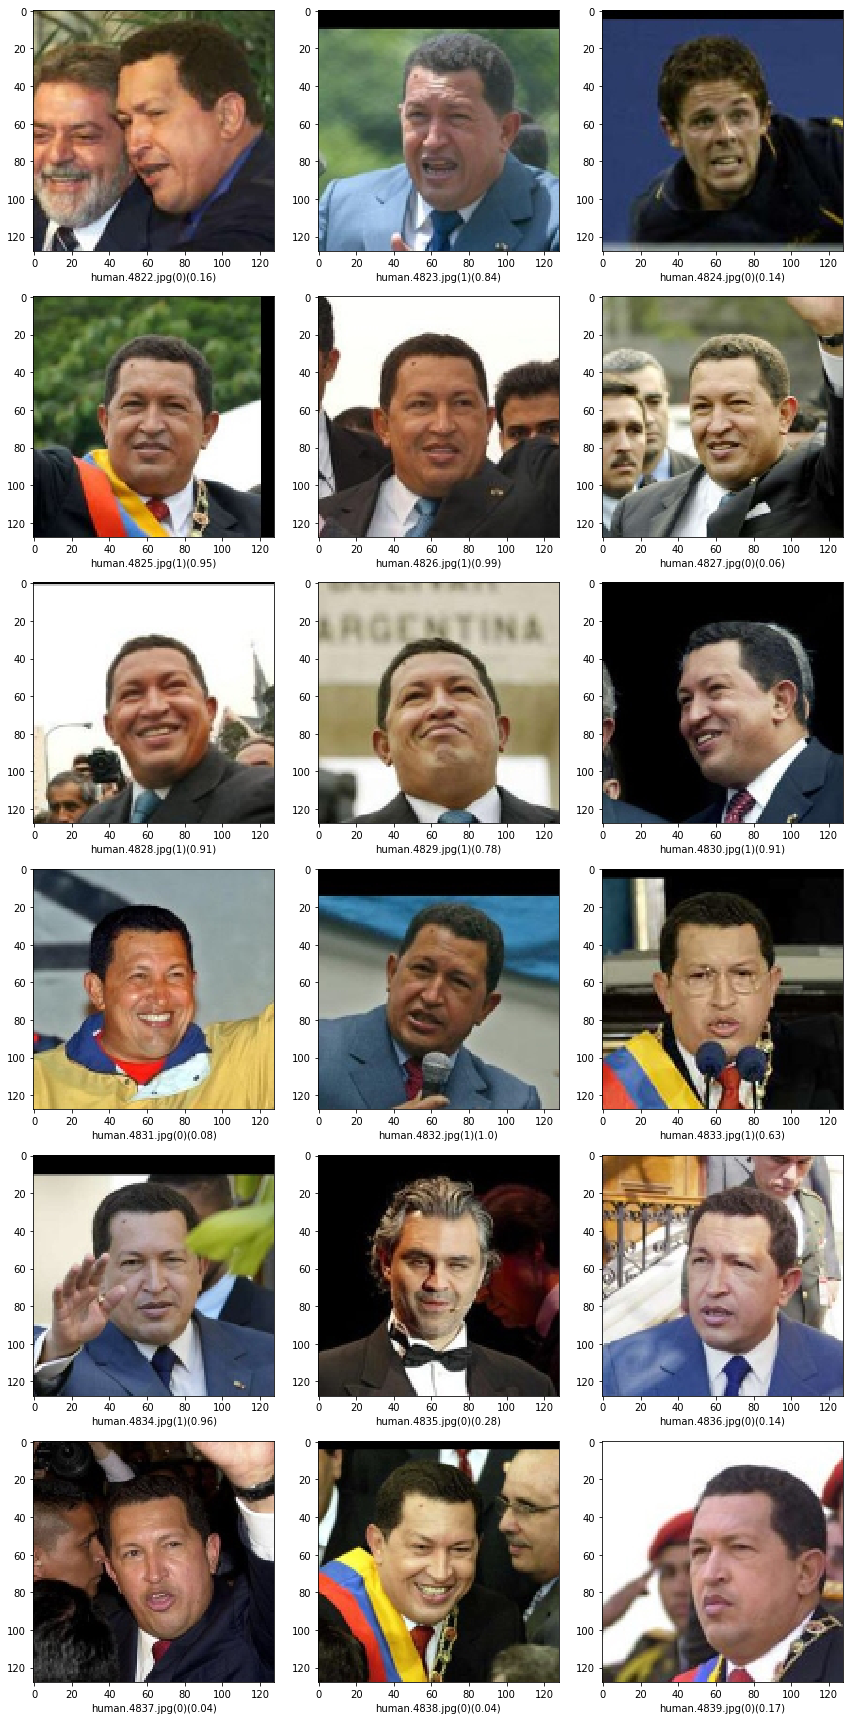

In [84]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    probability = row['probability'] 
    img = load_img("data/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' '(' + "{}".format(round(probability, 2)) + ')')
plt.tight_layout()
plt.show()